In [1]:
%pylab inline
import pandas as pd

sample_info = pd.read_csv('MOB_sample_info.csv', index_col=0)

df = pd.read_csv('data/Rep11_MOB_0.csv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

import NaiveDE

dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

Populating the interactive namespace from numpy and matplotlib


In [2]:
results = pd.read_csv('MOB_final_results.csv', index_col=0)

results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)

sres = results.query('qval < 0.05 & g != "log_total_count"').copy()

X = sample_info[['x', 'y']].values
Y = res[sres['g']].values.T

# This is important
Y = (Y.T - Y.mean(1)).T
Y = (Y.T / Y.std(1)).T

In [3]:
from SpatialDE import base

In [4]:
K = base.SE_kernel(X, 1.)
s2e = 1.
C = 5
G = Y.shape[0]
N = Y.shape[1]

In [5]:
def Q_Z_expectation(mu, Y, s2e, N, C, G, pi=None):
    if pi is None:
        pi = np.ones(C) / C

    log_rho = np.log(pi[None, :]) \
              - 0.5 * N * np.log(s2e) \
              - 0.5 * np.sum((mu.T[None, :, :] - Y[:, None, :]) ** 2, 2) / s2e \
              - 0.5 * N * np.log(2 * np.pi)

    # Subtract max per row for numerical stability
    rho = np.exp(log_rho - log_rho.max(1)[:, None])
    # Then evaluate softmax
    r = (rho.T / (rho.sum(1))).T
    
    return r

In [6]:
def Q_mu_k_expectation(Z_k, Y, K, s2e):
    y_k_tilde = np.dot(Z_k, Y) / s2e
    Sytk = np.dot(K, y_k_tilde)
    IpSDk = np.eye(K.shape[0]) + K * Z_k.sum() / s2e
    m_k = np.linalg.solve(IpSDk, Sytk)
    
    return m_k

def Q_mu_expectation(Z, Y, K, s2e):
    m = np.zeros((Y.shape[1], Z.shape[1]))

    y_k_tilde = np.dot(Z.T, Y).T / s2e

    for k in range(Z.shape[1]):
        m[:, k] = Q_mu_k_expectation(Z[:, k], Y, K, s2e)

    return m

In [7]:
# Expecation of ln P(Y | Z, mu, s2e)
def ln_P_YZms(Y, Z, mu, s2e, pi=None):
    G = Y.shape[0]
    C = Z.shape[1]
    if pi is None:
        pi = np.ones(C) / C
    
    log_rho = np.log(pi[None, :]) \
              - 0.5 * N * np.log(s2e) \
              - 0.5 * np.sum((mu.T[None, :, :] - Y[:, None, :]) ** 2, 2) / s2e \
              - 0.5 * N * np.log(2 * np.pi)
            
    return (Z * log_rho).sum()

# Expectation of ln P(mu)
def ln_P_mu(mu, K):
    N = K.shape[0]
    C = mu.shape[1]
    ll = 0
    for k in range(C):
        ll = ll + np.linalg.det(K)
        ll = ll + mu[:, k].dot(np.linalg.solve(K, mu[:, k]))
        ll = ll + N * np.log(2 * np.pi)
        
    ll = -0.5 * ll
    
    return ll

# Expectation of ln P(Z)
def ln_P_Z(Z, pi=None):
    C = Z.shape[1]
    if pi is None:
        pi = np.ones(C) / C
        
    return np.dot(Z, np.log(pi)).sum()

# Expecation of ln Q(mu)
def ln_Q_mu(K, Z, s2e):
    N = K.shape[0]
    C = Z.shape[1]
    G_k = Z.sum(0)
    
    ll = 0
    U, S = base.factor(K)
    for k in range(C):
        ll = ll - (1. / S + G_k[k] / s2e).sum()
        ll = ll + N * np.log(2 * np.pi)
        
    
    ll = -0.5 * ll
    
    return ll

# Expectation of ln Q(Z)
def ln_Q_Z(Z, r):
    return np.sum(Z * np.log(r))


In [8]:
def ELBO(Y, r, m, s2e, K, K_0, s2e_0, pi=None):
    L = ln_P_YZms(Y, r, m, s2e, pi) + ln_P_Z(r, pi) + ln_P_mu(m, K) \
        - ln_Q_Z(r, r) - ln_Q_mu(K_0, r, s2e_0)
    
    return L

In [9]:
def make_elbojective(Y, r, m, X, K_0, s2e_0, pi=None):
    def elbojective(log_s2e):
        return -ELBO(Y, r, m, np.exp(log_s2e), K_0, K_0, s2e_0, pi)
    
    return elbojective

In [10]:
from scipy import optimize

In [48]:
def fit_patterns(X, Y, C, l, s2e_0=1.0, verbosity=0, maxiter=100, printerval=1, opt_interval=1, delta_elbo_threshold=1e-4):
    # Set up constants
    G = Y.shape[0]
    N = Y.shape[1]
    eps = 1e-8 * np.eye(N)
    
    s2e = s2e_0
    
    K = base.SE_kernel(X, l) + eps
    
    # Randomly initialize
    r = np.random.uniform(size=(G, C))
    r = r / r.sum(0)
    
    pi = r.sum(0) / G

    m = np.random.normal(size=(N, C))
    
    elbo_0 = ELBO(Y, r, m, s2e, K, K, s2e, pi)
    elbo_1 = elbo_0

    if verbosity > 0:
        print('iter {}, ELBO: {:0.2e}'.format(0, elbo_1))

    if verbosity > 1:
        print()

    for i in range(maxiter):
        if (i % opt_interval == (opt_interval - 1)):
            elbojective = make_elbojective(Y, r, m, X, K, s2e, pi)
            
            o = optimize.minimize_scalar(elbojective)
            s2e = np.exp(o.x)
            
            
        r = Q_Z_expectation(m, Y, s2e, N, C, G, pi)
        m = Q_mu_expectation(r, Y, K, s2e)
        
        pi = r.sum(0) / G

        elbo_0 = elbo_1
        elbo_1 = ELBO(Y, r, m, s2e, K, K, s2e, pi)
        delta_elbo = np.abs(elbo_1 - elbo_0)

        if verbosity > 0 and (i % printerval == 0):
            print('iter {}, ELBO: {:0.2e}, delta_ELBO: {:0.2e}'.format(i + 1, elbo_1, delta_elbo))
            
            if verbosity > 1:
                print('ln(l): {:0.2f}, ln(s2e): {:.2f}'.format(np.log(l), np.log(s2e)))
                
            if verbosity > 2:
                line1 = 'P(Y | Z, mu, s2e): {:0.2e}, P(Z): {:0.2e}, P(mu): {:0.2e}' \
                        .format(ln_P_YZms(Y, r, m, s2e, pi), ln_P_Z(r, pi), ln_P_mu(m, K))
                line2 = 'Q(Z): {:0.2e}, Q(mu): {:0.2e}'.format(ln_Q_Z(r, r), ln_Q_mu(K, r, s2e))
                print(line1 + '\n' + line2)
            
            if verbosity > 1:
                print()
            
        if delta_elbo < delta_elbo_threshold:
            if verbosity > 0:
                print('Converged on iter {}'.format(i + 1))

            break
            
    else:
        print('Warning! ELBO dit not converge after {} iters!'.format(i + 1))

    final_elbo = ELBO(Y, r, m, s2e, K, K, s2e, pi)
        
    return final_elbo, m, r, s2e

In [50]:
Y = res[sres['g']].values.T

# This is important
Y = (Y.T - Y.mean(1)).T
Y = (Y.T / Y.std(1)).T

C = 5
elbo, m, r, s2e = fit_patterns(X, Y, C, 1.5, verbosity=0, printerval=1, maxiter=200)

K = base.SE_kernel(X, l)

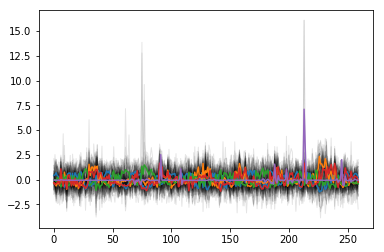

In [51]:
figsize(6, 4)
for g in range(G):
    plt.plot(range(Y.shape[1]), Y[g], lw=1, c='k', alpha=0.1)
    
plt.plot(m);

In [52]:
sres['pattern'] = r.argmax(1)

In [57]:
r.argmax(1)

array([0, 2, 0, 0, 0, 2, 2, 4, 4, 1, 2, 1, 2, 2, 1, 1, 0, 1, 1, 2, 0, 0, 1,
       0, 1, 1, 3, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 2, 0, 1, 1, 1, 1,
       2, 1, 2, 2, 2, 1, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 2, 0, 1, 3, 1])

In [58]:
r.max(1)

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  0.99999952,
        1.        ,  1.        ,  1.        ,  0.99998242,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  0.99999995,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  0.99995051,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  0.99999999,
        1.        ,  0.99731849,  1.        ,  0.99999845,  1.        ,
        1.        ,  1.        ])

In [60]:
pd.DataFrame.from_records(m)

,0,1,2,3,4
0,0.415062,-0.337355,-0.049561,-0.323902,-0.054404
1,0.488679,-0.413282,0.020090,-0.506600,-0.061807
2,0.694463,-0.632419,-0.194693,-0.359768,-0.061289
3,0.380140,-0.383488,0.247920,-0.330463,-0.061589
4,0.312927,-0.318929,0.072376,-0.057979,-0.055057
5,-0.072984,-0.607649,-0.267180,-0.443285,-0.080704
6,-0.192812,0.762895,-0.749332,1.091230,0.001599
7,-0.120212,-0.259751,-0.530299,-0.025363,-0.030165
8,-0.413451,-0.581029,0.535462,-0.691144,-0.052813
9,-0.770657,0.761959,-0.062321,-0.011967,-0.053835


In [53]:
np.unique(sres.pattern).shape

(5,)

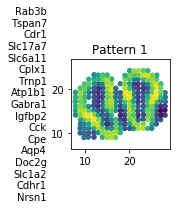

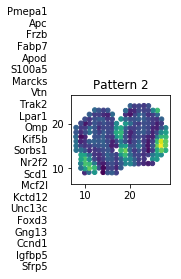

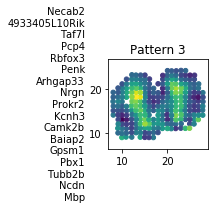

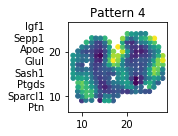

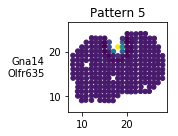

In [54]:
figsize(2, 2)
for k in np.unique(r.argmax(1)):
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=(m[:, k]), s=20)
    plt.axis('equal')
    plt.title('Pattern {}'.format(k + 1))
    plt.tight_layout()
    plt.ylabel('\n'.join(sres.query('pattern == @k')['g']), rotation=0, va='center', ha='right')